In [1]:
import warnings
warnings.filterwarnings('ignore')
# For ignoring warnings printed by R magic commands

In [2]:
# Load R magic
%load_ext rpy2.ipython

In [3]:
# %%R
# # Install ggthemes package (if it's not installed)
# install.packages("ggthemes", repos="http://cran.us.r-project.org")

In [4]:
%%R
library(ggplot2)
library(ggthemes)
library(RColorBrewer)
library(stringr)
# library(tidyverse)
library(grid)
library(gridExtra)

# blues = brewer.pal(n = 6, "Blues")[4:6]
# plot_theme <- theme_hc() + theme(legend.title=element_blank(), 
#                                 legend.position="right", 
#                                 legend.text=element_text(size=12))

In [5]:
%matplotlib notebook
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os

In [6]:
def df_plot_cdf(data, colname, **kwargs):
    df = pd.DataFrame()
    df['counts'] = data.groupby(colname)[colname].count()
    df['cumsum'] = df['counts'].cumsum()
    df['cdf'] = df['cumsum']/float(df['counts'].sum())
    df['cdf'].plot(**kwargs)

# Priority Thread Scheduling

In [7]:
def plot_load_cdfs_sched(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data[data['context'] == 0], 'resp_time', label='{}-C0'.format(m))
        df_plot_cdf(data[data['context'] == 1], 'resp_time', label='{}-C1'.format(m))
        print('Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data)))

In [8]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_sched(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        for c in [0, 1]:
            # extract all data for this context at this load
            req_context_df = req_load_df[req_load_df['context'] == c]
            resp_context_df = resp_load_df[resp_load_df['context'] == c]
            # add dummy rows with infinite resp time if needed
            if len(resp_context_df) < len(req_context_df):
                dummy_row = resp_context_df.head(1).copy()
                dummy_row['resp_time'] = 1e100
                dummy_rows = pd.concat([dummy_row]*(len(req_context_df) - len(resp_context_df)), ignore_index=True)
                resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
            elif len(resp_context_df) > len(req_context_df):
                print("WARNING: more responses ({}) received than requests sent ({})! m={}, c={}".format(len(resp_context_df), len(req_context_df), m, c))
    return resp_df

In [9]:
# The target load is different from the actual load.
# So we need to compute the actual load by looking at the request data.
def get_load_map(req_df):
    # create a dict that maps {mean_arrival_time ==> load}
    load_map = {}
    for m in req_df['mean_arrival_time'].unique():
        load_data = req_df[req_df['mean_arrival_time'] == m]
        mean_arrival_time = load_data['sent_time'].diff().mean()
        load_map[m] = 1e3/(mean_arrival_time/3.2) # MRPS
    return load_map

In [10]:
def process_resp_time_sched(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_sched(resp_df, req_df)
    c0_tail = resp_df[resp_df['context'] == 0].groupby('load')['resp_time'].quantile(0.99)
    c1_tail = resp_df[resp_df['context'] == 1].groupby('load')['resp_time'].quantile(0.99)
    c0_median = resp_df[resp_df['context'] == 0].groupby('load')['resp_time'].quantile(0.50)
    c1_median = resp_df[resp_df['context'] == 1].groupby('load')['resp_time'].quantile(0.50)
    return c0_tail, c1_tail, c0_median, c1_median

In [11]:
# resdir = 'results-workload/2020-08-07--23-00-55-lnic-evaluation/switch0' # goarse-grained
# resdir = 'results-workload/2020-08-09--01-11-27-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/scheduling/lnic-driven/load-sweep'
lnic_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
lnic_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
lnic_sched_tail_c0, lnic_sched_tail_c1, lnic_sched_median_c0, lnic_sched_median_c1 = process_resp_time_sched(lnic_sched_stats, lnic_sched_req_stats)

In [12]:
# resdir = 'results-workload/2020-08-07--23-25-24-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--00-47-51-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/scheduling/timer-driven/load-sweep'
timer_sched_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
timer_sched_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
timer_sched_tail_c0, timer_sched_tail_c1, timer_sched_median_c0, timer_sched_median_c1 = process_resp_time_sched(timer_sched_stats, timer_sched_req_stats)

<IPython.core.display.Javascript object>


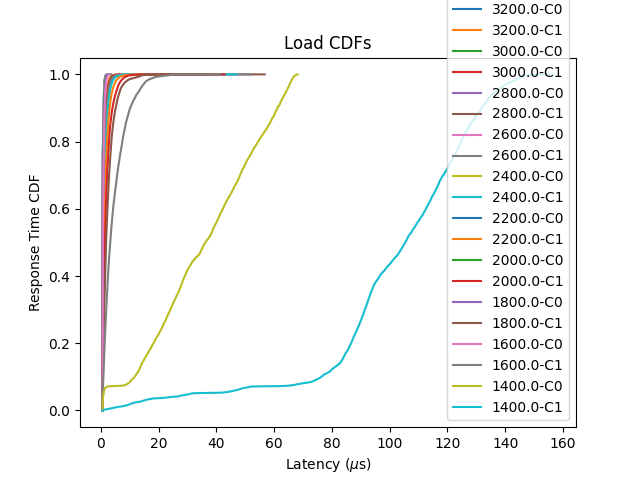

Num Requests @ mean_arrival_time 3200.0 cycles = 20000
Num Requests @ mean_arrival_time 3000.0 cycles = 20000
Num Requests @ mean_arrival_time 2800.0 cycles = 20000
Num Requests @ mean_arrival_time 2600.0 cycles = 20000
Num Requests @ mean_arrival_time 2400.0 cycles = 20000
Num Requests @ mean_arrival_time 2200.0 cycles = 20000
Num Requests @ mean_arrival_time 2000.0 cycles = 20000
Num Requests @ mean_arrival_time 1800.0 cycles = 20000
Num Requests @ mean_arrival_time 1600.0 cycles = 20000
Num Requests @ mean_arrival_time 1400.0 cycles = 17553


In [13]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(lnic_sched_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


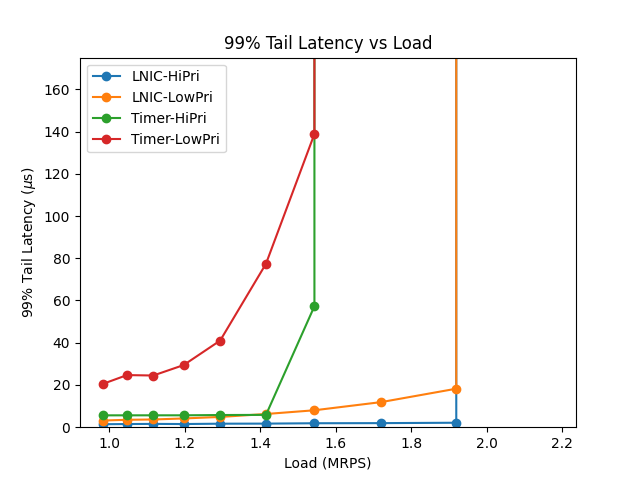

In [14]:
# Plot tail latency vs load
plt.figure()
lnic_sched_tail_c0.plot(marker='o', label='LNIC-HiPri')
lnic_sched_tail_c1.plot(marker='o', label='LNIC-LowPri')
timer_sched_tail_c0.plot(marker='o', label='Timer-HiPri')
timer_sched_tail_c1.plot(marker='o', label='Timer-LowPri')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 175])
plt.show()

<IPython.core.display.Javascript object>


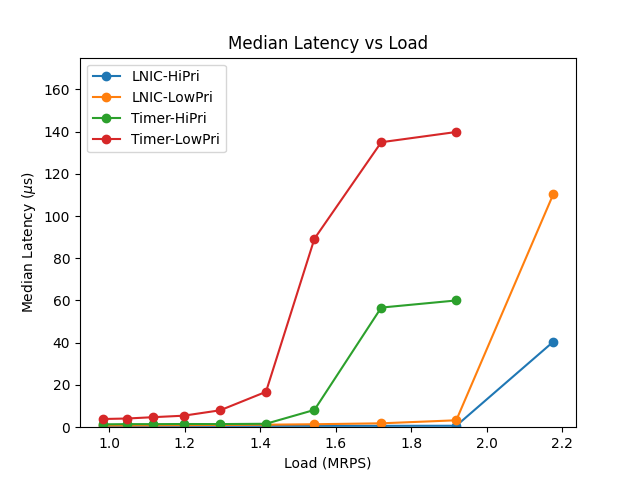

In [15]:
# Plot median latency vs load
plt.figure()
lnic_sched_median_c0.plot(marker='o', label='LNIC-HiPri')
lnic_sched_median_c1.plot(marker='o', label='LNIC-LowPri')
timer_sched_median_c0.plot(marker='o', label='Timer-HiPri')
timer_sched_median_c1.plot(marker='o', label='Timer-LowPri')
plt.title('Median Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('Median Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 175])
plt.show()

In [16]:
lnic_sched_tail_c0
# lnic_sched_tail_c1
# timer_sched_tail_c0
# timer_sched_tail_c1

load
0.981954     1.407150e+00
1.046743     1.494238e+00
1.116528     1.564641e+00
1.196994     1.495775e+00
1.293689     1.659887e+00
1.415184     1.695938e+00
1.543584     1.869959e+00
1.720741     1.925906e+00
1.919577     2.111672e+00
2.177177    1.000000e+100
Name: resp_time, dtype: float64

In [17]:
lnic_hipri_tail_lat_df = pd.DataFrame()
lnic_hipri_tail_lat_df['Latency'] = pd.Series(lnic_sched_tail_c0)
lnic_hipri_tail_lat_df['Run'] = 'nanoPU-HiPri'
lnic_hipri_tail_lat_df['Perc'] = 'Tail (99th)'
lnic_hipri_tail_lat_df['Load'] = lnic_hipri_tail_lat_df.index
lnic_lowpri_tail_lat_df = pd.DataFrame()
lnic_lowpri_tail_lat_df['Latency'] = pd.Series(lnic_sched_tail_c1)
lnic_lowpri_tail_lat_df['Run'] = 'nanoPU-LowPri'
lnic_lowpri_tail_lat_df['Perc'] = 'Tail (99th)'
lnic_lowpri_tail_lat_df['Load'] = lnic_lowpri_tail_lat_df.index

timer_hipri_tail_lat_df = pd.DataFrame()
timer_hipri_tail_lat_df['Latency'] = pd.Series(timer_sched_tail_c0)
timer_hipri_tail_lat_df['Run'] = 'Timer-HiPri'
timer_hipri_tail_lat_df['Perc'] = 'Tail (99th)'
timer_hipri_tail_lat_df['Load'] = timer_hipri_tail_lat_df.index
timer_lowpri_tail_lat_df = pd.DataFrame()
timer_lowpri_tail_lat_df['Latency'] = pd.Series(timer_sched_tail_c1)
timer_lowpri_tail_lat_df['Run'] = 'Timer-LowPri'
timer_lowpri_tail_lat_df['Perc'] = 'Tail (99th)'
timer_lowpri_tail_lat_df['Load'] = timer_lowpri_tail_lat_df.index

ts_tail_lat_df = pd.concat([timer_lowpri_tail_lat_df, timer_hipri_tail_lat_df, lnic_lowpri_tail_lat_df, lnic_hipri_tail_lat_df])



In [18]:
# ts_tail_lat_df

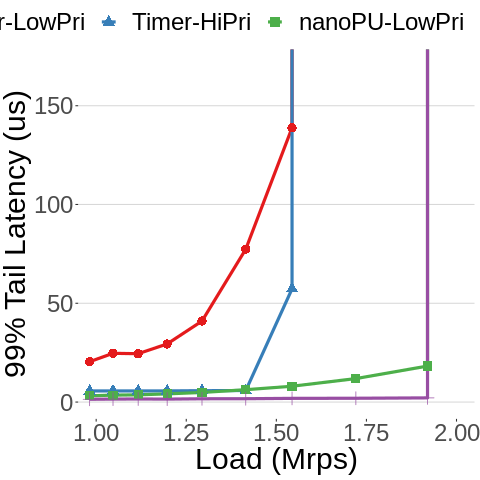

In [57]:
%%R -i ts_tail_lat_df
ts_tail_lat_df$Run <- factor(ts_tail_lat_df$Run, levels = c("Timer-LowPri", "Timer-HiPri", "nanoPU-LowPri", "nanoPU-HiPri"))

ggplot(ts_tail_lat_df, aes(y=Latency, x=Load, colour=Run)) + 
    geom_line(size=1.5) +
    geom_point(aes(shape=Run), size=4) +
    coord_cartesian(xlim = c(1, 2), ylim = c(0, 170)) +
#     facet_grid(factor(Perc) ~ .) +
    labs(y = "99% Tail Latency (us)", x = "Load (Mrps)") +
    theme_hc(base_size = 30) +
    theme(legend.position = "top", legend.title = element_blank()) +
    scale_colour_brewer(palette = "Set1")

In [58]:
%%R -i ts_tail_lat_df
ggsave("plots/thread_sched_tail_latency.pdf", width = 12, height = 5)

#### Notes:
* If the NIC was smarter about allocating buffer space for each context then the high priority (Context 0) thread would probably be able to achieve higher throughput for the LNIC-driven approach. Right now, msgs are dropped for both contexts when queues fill up. Really, only the C1 queue is filling up so only those msgs should be dropped.
* A pretty easy fix for this would be to only allow each context to use a max number of buffers in the reassembly module.

# Bounded Processing Time

In [46]:
# resdir = 'results-workload/2020-08-07--23-41-53-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--01-42-09-lnic-evaluation/switch0' # fine-grained
# resdir = 'results-workload/2020-08-09--20-05-50-lnic-evaluation/switch0' # fixed request rate
resdir = 'nanoPU-results/scheduling/bounded/load-sweep'
bounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
bounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
bounded_tail_c0, bounded_tail_c1, bounded_median_c0, bounded_median_c1 = process_resp_time_sched(bounded_stats, bounded_req_stats)

In [47]:
# resdir = 'results-workload/2020-08-07--23-50-45-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--01-33-54-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/scheduling/unbounded/load-sweep'
unbounded_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
unbounded_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
unbounded_tail_c0, unbounded_tail_c1, unbounded_median_c0, unbounded_median_c1 = process_resp_time_sched(unbounded_stats, unbounded_req_stats)

<IPython.core.display.Javascript object>


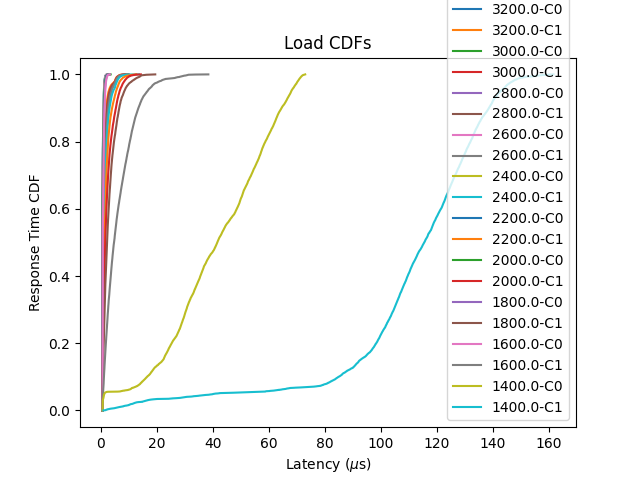

Num Requests @ mean_arrival_time 3200.0 cycles = 20000
Num Requests @ mean_arrival_time 3000.0 cycles = 20000
Num Requests @ mean_arrival_time 2800.0 cycles = 20000
Num Requests @ mean_arrival_time 2600.0 cycles = 20000
Num Requests @ mean_arrival_time 2400.0 cycles = 20000
Num Requests @ mean_arrival_time 2200.0 cycles = 20000
Num Requests @ mean_arrival_time 2000.0 cycles = 20000
Num Requests @ mean_arrival_time 1800.0 cycles = 20000
Num Requests @ mean_arrival_time 1600.0 cycles = 20000
Num Requests @ mean_arrival_time 1400.0 cycles = 16805


In [48]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_sched(bounded_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


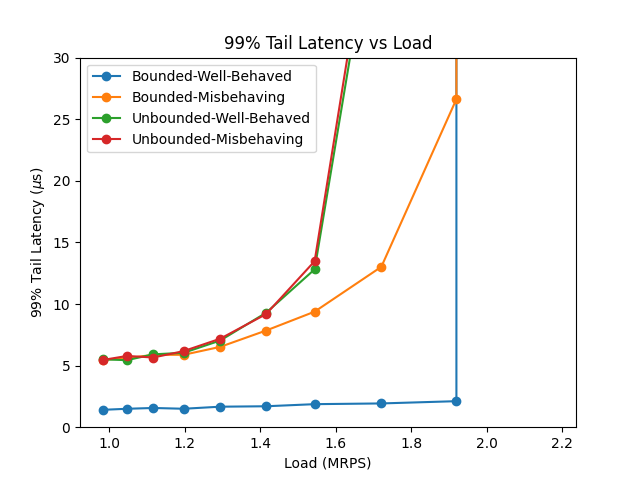

In [49]:
# Plot tail latency vs load
plt.figure()
bounded_tail_c0.plot(marker='o', label='Bounded-Well-Behaved')
bounded_tail_c1.plot(marker='o', label='Bounded-Misbehaving')
unbounded_tail_c0.plot(marker='o', label='Unbounded-Well-Behaved')
unbounded_tail_c1.plot(marker='o', label='Unbounded-Misbehaving')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 30])
plt.show()

In [50]:
bounded_wbhv_tail_lat_df = pd.DataFrame()
bounded_wbhv_tail_lat_df['Latency'] = pd.Series(bounded_tail_c0)
bounded_wbhv_tail_lat_df['Run'] = 'Bounded, Well Behaved'
bounded_wbhv_tail_lat_df['Load'] = bounded_wbhv_tail_lat_df.index
bounded_mbhv_tail_lat_df = pd.DataFrame()
bounded_mbhv_tail_lat_df['Latency'] = pd.Series(bounded_tail_c1)
bounded_mbhv_tail_lat_df['Run'] = 'Bounded, Misbehaving'
bounded_mbhv_tail_lat_df['Load'] = bounded_mbhv_tail_lat_df.index

unbounded_wbhv_tail_lat_df = pd.DataFrame()
unbounded_wbhv_tail_lat_df['Latency'] = pd.Series(unbounded_tail_c0)
unbounded_wbhv_tail_lat_df['Run'] = 'Unbounded, Well Behaved'
unbounded_wbhv_tail_lat_df['Load'] = unbounded_wbhv_tail_lat_df.index
unbounded_mbhv_tail_lat_df = pd.DataFrame()
unbounded_mbhv_tail_lat_df['Latency'] = pd.Series(unbounded_tail_c1)
unbounded_mbhv_tail_lat_df['Run'] = 'Unbounded, Misbehaving'
unbounded_mbhv_tail_lat_df['Load'] = unbounded_mbhv_tail_lat_df.index

bp_tail_lat_df = pd.concat([bounded_wbhv_tail_lat_df, bounded_mbhv_tail_lat_df, unbounded_wbhv_tail_lat_df, unbounded_mbhv_tail_lat_df])



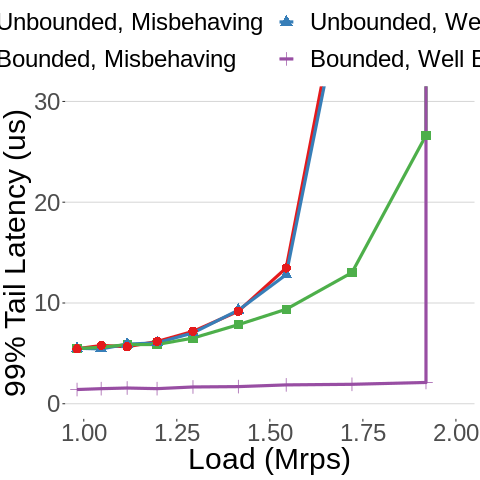

In [59]:
%%R -i bp_tail_lat_df
bp_tail_lat_df$Run <- factor(bp_tail_lat_df$Run, levels = c("Unbounded, Misbehaving", "Unbounded, Well Behaved", "Bounded, Misbehaving", "Bounded, Well Behaved"))

ggplot(bp_tail_lat_df, aes(y=Latency, x=Load, colour=Run)) + 
    geom_line(size=1.5) +
    geom_point(aes(shape=Run), size=4) +
    coord_cartesian(xlim = c(1, 2), ylim = c(0, 30)) +
#     facet_grid(factor(Perc) ~ .) +
    labs(y = "99% Tail Latency (us)", x = "Load (Mrps)") +
    theme_hc(base_size = 30) +
    theme(legend.position = "top", legend.title = element_blank()) +
    guides(col = guide_legend(nrow = 2, byrow = TRUE)) +
    scale_colour_brewer(palette = "Set1")

In [60]:
%%R -i bp_tail_lat_df
ggsave("plots/bounded_proc_tail_latency.pdf", width = 12, height = 5)

# Load Balancing

In [28]:
def plot_load_cdfs_lb(df):
    for m in df['mean_arrival_time'].unique():
        data = df[df['mean_arrival_time'] == m]
        df_plot_cdf(data, 'resp_time', label='{}'.format(m))
        print('Num Requests @ mean_arrival_time {} cycles = {}'.format(m, len(data)))

In [61]:
# If the number of responses is less than the number of
# requests that were sent then need to pad the data with
# infinite response times.
def pad_resp_df_lb(resp_df, req_df):
    for m in req_df['mean_arrival_time'].unique():
        # extract all data for this load
        req_load_df = req_df[req_df['mean_arrival_time'] == m]
        resp_load_df = resp_df[resp_df['mean_arrival_time'] == m]
        # add dummy rows with infinite resp time if needed
        if len(resp_load_df) < len(req_load_df):
            dummy_row = resp_load_df.head(1).copy()
            dummy_row['resp_time'] = 1e100
            dummy_rows = pd.concat([dummy_row]*(len(req_load_df) - len(resp_load_df)), ignore_index=True)
            resp_df = pd.concat([resp_df, dummy_rows], ignore_index=True)
        elif len(resp_load_df) > len(req_load_df):
            print("WARNING: more responses ({}) received than requests sent ({})! m={}".format(len(resp_load_df), len(req_load_df), m))
    return resp_df

In [62]:
def process_resp_time_lb(resp_df, req_df):
    # compute load
    load_map = get_load_map(req_df)
    resp_df['load'] = resp_df[['mean_arrival_time']].applymap(lambda x: load_map[x])
    # convert resp_time from cycles to us
    resp_df['resp_time'] /= 3.2e3
    # compute and return tail latency
    resp_df = pad_resp_df_lb(resp_df, req_df)
    tail = resp_df.groupby('load')['resp_time'].quantile(0.99)
    return tail

In [63]:
# resdir = 'results-workload/2020-08-08--00-40-06-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--02-11-54-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/load-balance/rss/load-sweep'
rss_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
rss_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
rss_tail = process_resp_time_lb(rss_stats, rss_req_stats)

In [64]:
# resdir = 'results-workload/2020-08-08--00-44-00-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--02-17-40-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/load-balance/jbsq/load-sweep'
jbsq_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_tail = process_resp_time_lb(jbsq_stats, jbsq_req_stats)

In [65]:
# resdir = 'results-workload/2020-08-08--00-48-38-lnic-evaluation/switch0' # coarse-grained
# resdir = 'results-workload/2020-08-09--02-30-24-lnic-evaluation/switch0' # fine-grained
resdir = 'nanoPU-results/load-balance/jbsq-pre/load-sweep'
jbsq_pre_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
jbsq_pre_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
jbsq_pre_tail = process_resp_time_lb(jbsq_pre_stats, jbsq_pre_req_stats)

<IPython.core.display.Javascript object>


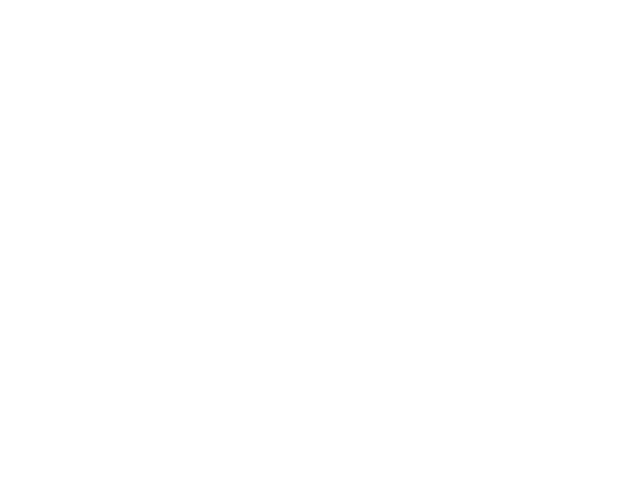

NameError: name 'plot_load_cdfs_lb' is not defined

In [66]:
# Plot response time CDF for each load
plt.figure()
plot_load_cdfs_lb(jbsq_pre_stats)
plt.title('Load CDFs')
plt.xlabel('Latency ($\mu$s)')
plt.ylabel('Response Time CDF')
plt.legend(loc='lower right')
plt.show()

<IPython.core.display.Javascript object>


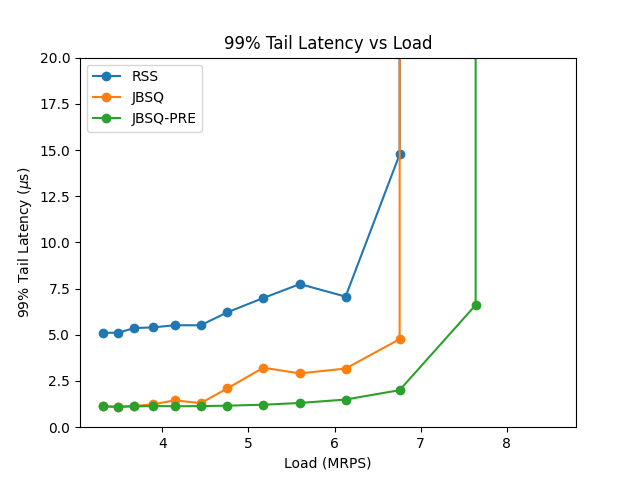

In [67]:
# Plot tail latency vs load
plt.figure()
rss_tail.plot(marker='o', label='RSS')
jbsq_tail.plot(marker='o', label='JBSQ')
jbsq_pre_tail.plot(marker='o', label='JBSQ-PRE')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 20])
plt.show()

In [68]:
rss_tail_lat_df = pd.DataFrame()
rss_tail_lat_df['Latency'] = pd.Series(rss_tail)
rss_tail_lat_df['Run'] = 'RSS'
rss_tail_lat_df['Load'] = rss_tail_lat_df.index
jbsq_tail_lat_df = pd.DataFrame()
jbsq_tail_lat_df['Latency'] = pd.Series(jbsq_tail)
jbsq_tail_lat_df['Run'] = 'JBSQ'
jbsq_tail_lat_df['Load'] = jbsq_tail_lat_df.index
jbsq_pre_tail_lat_df = pd.DataFrame()
jbsq_pre_tail_lat_df['Latency'] = pd.Series(jbsq_pre_tail)
jbsq_pre_tail_lat_df['Run'] = 'JBSQ-PRE'
jbsq_pre_tail_lat_df['Load'] = jbsq_pre_tail_lat_df.index

lb_tail_lat_df = pd.concat([rss_tail_lat_df, jbsq_tail_lat_df, jbsq_pre_tail_lat_df])



In [69]:
# lb_tail_lat_df

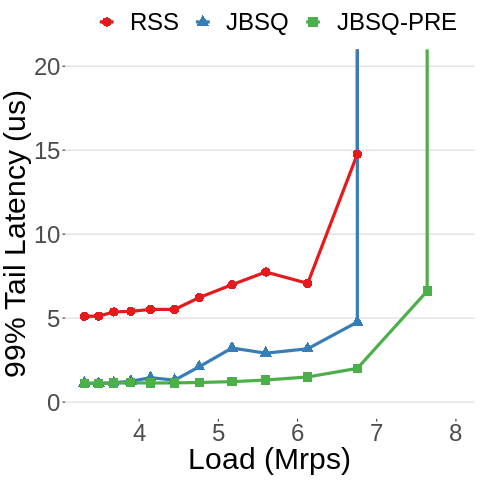

In [70]:
%%R -i lb_tail_lat_df
lb_tail_lat_df$Run <- factor(lb_tail_lat_df$Run, levels = c("RSS", "JBSQ", "JBSQ-PRE"))

ggplot(lb_tail_lat_df, aes(y=Latency, x=Load, colour=Run)) + 
    geom_line(size=1.5) +
    geom_point(aes(shape=Run), size=4) +
    coord_cartesian(xlim = c(3.3, 8), ylim = c(0, 20)) +
#     facet_grid(factor(Perc) ~ .) +
    labs(y = "99% Tail Latency (us)", x = "Load (Mrps)") +
    theme_hc(base_size = 30) +
    theme(legend.position = "top", legend.title = element_blank()) +
#     guides(col = guide_legend(nrow = 2, byrow = TRUE)) +
    scale_colour_brewer(palette = "Set1")

In [71]:
%%R -i lb_tail_lat_df
ggsave("plots/ld_balance_tail_latency.pdf", width = 12, height = 5)

# Incast

In [72]:
def process_qsize_stats(df):
    start_time = df[df['port'] == 0].index[1]
    df.index = (df.index - start_time)/3.2e3 # convert to us
    df['lp_bytes'] /= 1e3 # convert to KB
    df['hp_bytes'] /= 1e3 # convert to KB

In [73]:
resdir = 'nanoPU-results/incast/90host/ndp'
ndp_stats = pd.read_csv(os.path.join(resdir, 'qsize.csv'), index_col='time')
process_qsize_stats(ndp_stats)

In [74]:
resdir = 'nanoPU-results/incast/90host/no-ndp'
no_ndp_stats = pd.read_csv(os.path.join(resdir, 'qsize.csv'), index_col='time')
process_qsize_stats(no_ndp_stats)

<IPython.core.display.Javascript object>


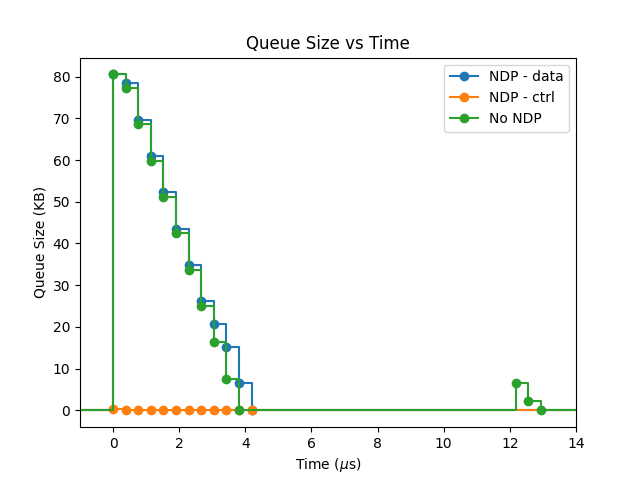

In [75]:
plt.figure()
ndp_stats[ndp_stats['port'] == 0]['lp_bytes'].plot(drawstyle="steps-post", marker='o', label='NDP - data')
ndp_stats[ndp_stats['port'] == 0]['hp_bytes'].plot(drawstyle="steps-post", marker='o', label='NDP - ctrl')
no_ndp_stats[no_ndp_stats['port'] == 0]['lp_bytes'].plot(drawstyle="steps-post", marker='o', label='No NDP')
plt.title('Queue Size vs Time')
plt.xlabel('Time ($\mu$s)')
plt.ylabel('Queue Size (KB)')
plt.legend(loc='upper right')
plt.xlim([-1, 14])
plt.show()

In [76]:
ndp_data_df = pd.DataFrame()
ndp_data_df['Queue_Size'] = pd.Series(ndp_stats[ndp_stats['port'] == 0]['lp_bytes'])
ndp_data_df['Run'] = 'NDP-Data'
ndp_data_df['Time'] = ndp_data_df.index
ndp_ctrl_df = pd.DataFrame()
ndp_ctrl_df['Queue_Size'] = pd.Series(ndp_stats[ndp_stats['port'] == 0]['hp_bytes'])
ndp_ctrl_df['Run'] = 'NDP-Ctrl'
ndp_ctrl_df['Time'] = ndp_ctrl_df.index

no_ndp_df = pd.DataFrame()
no_ndp_df['Queue_Size'] = pd.Series(no_ndp_stats[no_ndp_stats['port'] == 0]['lp_bytes'])
no_ndp_df['Run'] = 'Without NDP'
no_ndp_df['Time'] = no_ndp_df.index

ndp_df = pd.concat([ndp_data_df, ndp_ctrl_df, no_ndp_df])


In [77]:
# ndp_df

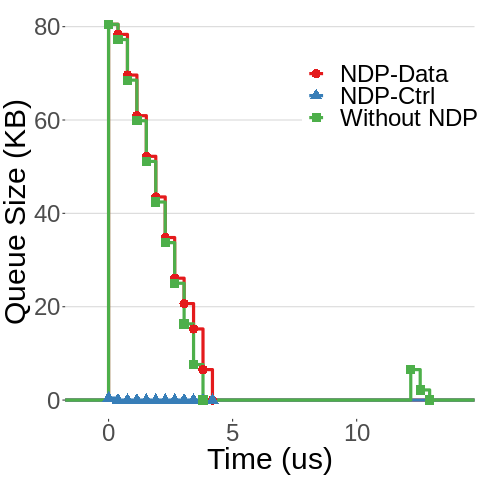

In [78]:
%%R -i ndp_df
ndp_df$Run <- factor(ndp_df$Run, levels = c("NDP-Data", "NDP-Ctrl", "Without NDP"))

ggplot(ndp_df, aes(y=Queue_Size, x=Time, colour=Run)) + 
    geom_step(size=1.5) +
    geom_point(aes(shape=Run), size=4) +
    coord_cartesian(xlim = c(-1, 14)) +
#     facet_grid(factor(Perc) ~ .) +
    labs(y = "Queue Size (KB)", x = "Time (us)") +
    theme_hc(base_size = 30) +
    theme(legend.position = c(.8, .8), legend.title = element_blank()) +
#     guides(col = guide_legend(nrow = 2, byrow = TRUE)) +
    scale_colour_brewer(palette = "Set1")

In [79]:
%%R -i ndp_df
ggsave("plots/ndp_queue_size.pdf", width = 12, height = 5)

# MICA

<IPython.core.display.Javascript object>


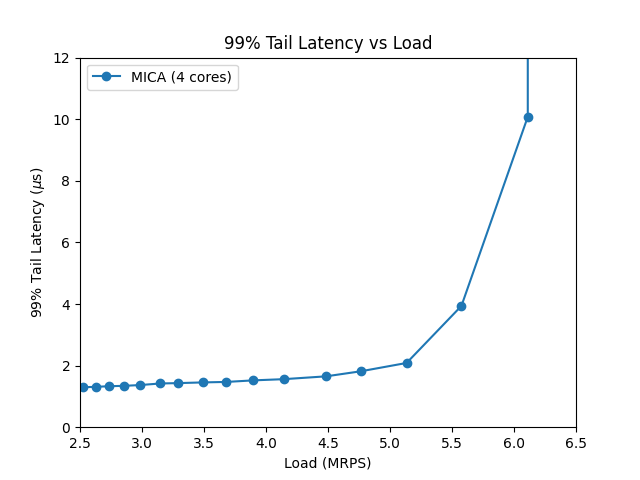

In [80]:
#resdir = 'results-workload/2020-08-13--05-48-16-lnic-multi-core-mica/switch0/'
resdir = 'nanoPU-results/mica/'
mica_stats = pd.read_csv(os.path.join(resdir, 'resp_time.csv'))
mica_req_stats = pd.read_csv(os.path.join(resdir, 'req_stats.csv'))
mica_tail = process_resp_time_sched(mica_stats, mica_req_stats)[0]

# Plot tail latency vs load
plt.figure()
mica_tail.plot(marker='o', label='MICA (4 cores)')
plt.title('99% Tail Latency vs Load')
plt.xlabel('Load (MRPS)')
plt.ylabel('99% Tail Latency ($\mu$s)')
plt.legend(loc='upper left')
plt.ylim([0, 12])
plt.xlim([2.5, 6.5])
plt.savefig('/tmp/tail.png')
plt.show()

In [49]:
mica_tail

load
2.527005     1.296875e+00
2.632603     1.311572e+00
2.736541     1.330950e+00
2.852561     1.342506e+00
2.983403     1.367816e+00
3.146822     1.419375e+00
3.293301     1.431566e+00
3.493546     1.454403e+00
3.680338     1.469691e+00
3.897481     1.520312e+00
4.143094     1.559687e+00
4.483679     1.650941e+00
4.764049     1.815012e+00
5.134045     2.085938e+00
5.576198     3.938759e+00
6.111148     1.007787e+01
6.741686    1.000000e+100
7.552207    1.000000e+100
8.529790    1.000000e+100
9.807758    1.000000e+100
Name: resp_time, dtype: float64

In [50]:
mica_tail_df = pd.DataFrame()
mica_tail_df['Latency'] = pd.Series(mica_tail)
mica_tail_df['Run'] = 'Mica'
mica_tail_df['Load'] = mica_tail_df.index

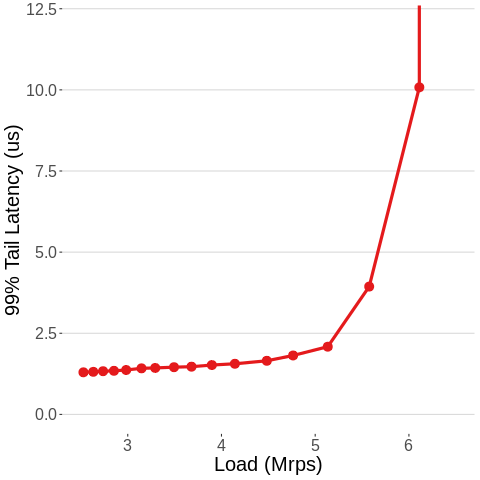

In [51]:
%%R -i mica_tail_df

ggplot(mica_tail_df, aes(y=Latency, x=Load, colour=Run)) + 
    geom_line(size=1.5) +
    geom_point(size=4) +
    coord_cartesian(xlim = c(2.5, 6.5), ylim = c(0, 12)) +
#     facet_grid(factor(Perc) ~ .) +
    labs(y = "99% Tail Latency (us)", x = "Load (Mrps)") +
    theme_hc(base_size = 20) +
    theme(legend.position = "", legend.title = element_blank()) +
#     guides(col = guide_legend(nrow = 2, byrow = TRUE)) +
    scale_colour_brewer(palette = "Set1")

In [52]:
%%R -i mica_tail_df
ggsave("plots/mica_tail_latency.pdf", width = 10, height = 3.5)